# LSTMs for stock market prediction

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [3]:
df=pd.read_csv('AMZN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
data=df[['Date','Close']]
data.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


C:\Users\Admin\AppData\Local\Temp\ipykernel_25964\480750277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date']=pd.to_datetime(data['Date'])


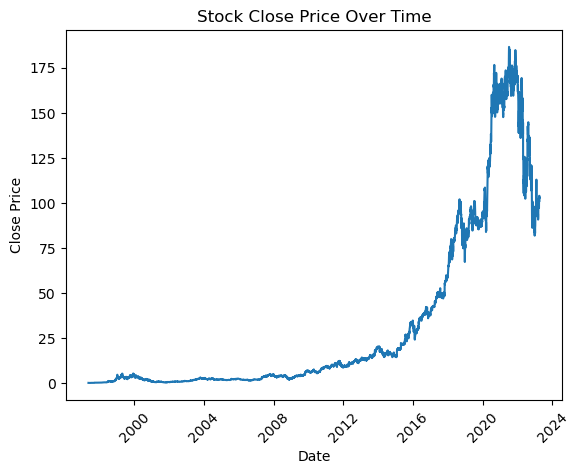

In [6]:
import datetime
import matplotlib.pyplot as plt
data['Date']=pd.to_datetime(data['Date'])

plt.plot(data['Date'].values, data['Close'].values)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time')
plt.xticks(rotation=45)
plt.show()


In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df=dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    for i in range(1,n_steps+1):
        df[f'Close-{i}'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df
lookback=7
shifted_df=prepare_dataframe_for_lstm(data,lookback)
shifted_df

,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [8]:
shifted_df_as_np=np.array(shifted_df)
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [11]:
X=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
X=dc(np.flip(X,axis=1))
X.shape, y.shape


((6509, 7), (6509,))

In [12]:
split_index = int(len(X)*0.95)
split_index

6183

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train=y[:split_index]
y_test=y[split_index:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [15]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X: list, y: list):
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, i: int) -> tuple:
        return self.X[i], self.y[i]

    def __repr__(self) -> str:
        return f"TimeSeriesDataset(X={self.X}, y={self.y})"

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
train_dataset

TimeSeriesDataset(X=tensor([[[-0.9997],
         [-0.9998],
         [-0.9998],
         ...,
         [-1.0000],
         [-1.0000],
         [-1.0000]],

        [[-0.9998],
         [-0.9998],
         [-0.9999],
         ...,
         [-1.0000],
         [-0.9999],
         [-0.9999]],

        [[-0.9998],
         [-0.9999],
         [-1.0000],
         ...,
         [-0.9999],
         [-0.9999],
         [-0.9999]],

        ...,

        [[ 0.8168],
         [ 0.8370],
         [ 0.8884],
         ...,
         [ 0.8670],
         [ 0.8460],
         [ 0.8177]],

        [[ 0.8370],
         [ 0.8884],
         [ 0.8883],
         ...,
         [ 0.8460],
         [ 0.8177],
         [ 0.8126]],

        [[ 0.8884],
         [ 0.8883],
         [ 0.8670],
         ...,
         [ 0.8177],
         [ 0.8126],
         [ 0.8578]]]), y=tensor([[-0.9999],
        [-0.9999],
        [-1.0000],
        ...,
        [ 0.8126],
        [ 0.8578],
        [ 0.8102]]))

In [18]:
from torch.utils.data import DataLoader
batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)

    def forward(self,x):
        batch_size=x.size(0)
        h0=torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0=torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out

model=LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [21]:
def train_one_epoch():
    model.train(True)
    print(f'Epochs:{epoch+1}')
    running_loss=0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output=model(x_batch)
        loss=loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if batch_index % 100 == 99: # print every 100 block
            avg_loss_across_batches = running_loss/100
            print('Batch{0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss=0.0
    print()

In [22]:
def validate_one_epoch():
    model.train(False)
    running_loss=0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output=model(x_batch)
            loss=loss_function(output,y_batch)
            running_loss += loss

    avg_loss_across_batches = running_loss/ len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('*************************************************')
    print()

In [23]:
learning_rate=0.001
num_epochs=10
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epochs:1
Batch100, Loss: 0.791
Batch200, Loss: 0.288
Batch300, Loss: 0.073

Val Loss: 0.097
*************************************************

Epochs:2
Batch100, Loss: 0.017
Batch200, Loss: 0.014
Batch300, Loss: 0.012

Val Loss: 0.025
*************************************************

Epochs:3
Batch100, Loss: 0.006
Batch200, Loss: 0.005
Batch300, Loss: 0.005

Val Loss: 0.013
*************************************************

Epochs:4
Batch100, Loss: 0.003
Batch200, Loss: 0.002
Batch300, Loss: 0.002

Val Loss: 0.008
*************************************************

Epochs:5
Batch100, Loss: 0.001
Batch200, Loss: 0.001
Batch300, Loss: 0.001

Val Loss: 0.007
*************************************************

Epochs:6
Batch100, Loss: 0.001
Batch200, Loss: 0.001
Batch300, Loss: 0.001

Val Loss: 0.004
*************************************************

Epochs:7
Batch100, Loss: 0.001
Batch200, Loss: 0.001
Batch300, Loss: 0.000

Val Loss: 0.004
*************************************************


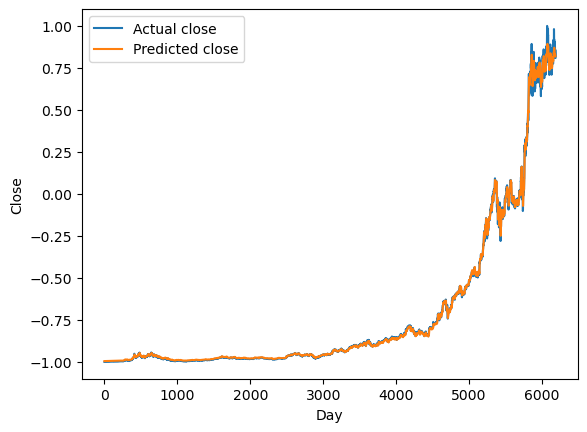

In [24]:
# Assuming X_train and y_train are tensors
with torch.no_grad():
    X_train = X_train.to(device)  # Move input data to device
    predicted = model(X_train)    # Forward pass through the model

# Plotting the results
plt.plot(y_train.cpu(), label='Actual close')   # Move y_train back to CPU if necessary
plt.plot(predicted.cpu(), label='Predicted close')  # Move predicted back to CPU if necessary
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
# Copy the CUDA tensor to CPU before converting to NumPy array
train_predictions = predicted.cpu().flatten()

# Continue with your remaining code...
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])


In [30]:
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

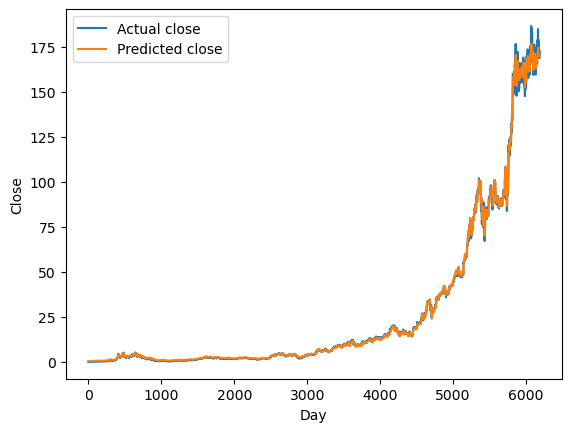

In [33]:

# Plotting the results
plt.plot(new_y_train, label='Actual close')   # Move y_train back to CPU if necessary
plt.plot(train_predictions, label='Predicted close')  # Move predicted back to CPU if necessary
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [37]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])


In [38]:
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

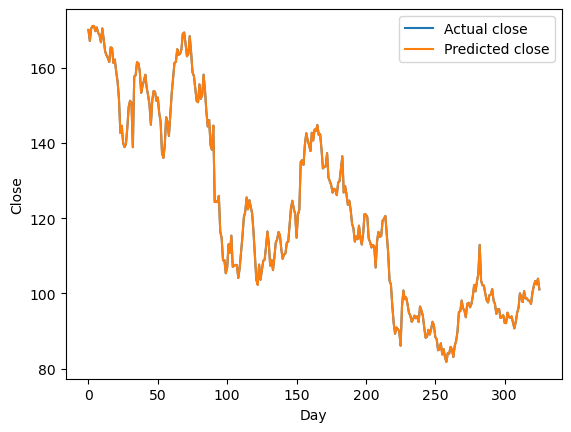

In [45]:

# Plotting the results
plt.plot(new_y_test, label='Actual close')   # Move y_train back to CPU if necessary
plt.plot(new_y_test, label='Predicted close')  # Move predicted back to CPU if necessary

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()